In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from tqdm import tqdm
from arviz import ess, convert_to_dataset

sns.set_style('whitegrid')

In [99]:
from numpy.random import normal, gamma

class NormalMean:
    def __init__(self, μ0, σ20):
        self.μ0 = μ0
        self.σ20 = σ20
        self.λ0 = np.sqrt(σ20)
    
    def sample_prior(self, size=1):
        sample = normal(loc=self.μ0, scale=np.sqrt(self.σ20), size=size)
        return sample
    
    def sample_posterior(self, n, mean, τ2, size=1):
        λ = 1 / τ2
        λn = λ * n + self.λ0

        σ2n = 1 / λn
        μn = σ2n * (λ * n * mean + self.μ0 * self.λ0)

        sample = normal(loc=μn, scale=np.sqrt(σ2n), size=1)
        return sample

class NomrlaPrec:
    def __init__(self, ν0, σ20):
        self.ν0 = ν0
        self.σ20 = σ20

    def sample_prior(self, size=1):
        β = 1/2 * (self.ν0 * self.σ20)
        sample = gamma(shape=self.ν0/2, scale=1/β, size=size)
        return sample
    
    def sample_posterior(self, n, scatter, size=1):
        νn = self.ν0 + n
        β = 1/2 * (self.ν0 * self.σ20 + scatter)
        sample = gamma(shape=νn/2, scale=1/β, size=size)
        return sample
        
def get_total_scatter(df, θs):
    scatter = 0
    for i, c in df.groupby('school'):
        scatter += np.sum((c.hours - θs[i])**2)
    return scatter

In [61]:
n_schools = 8

# read in all data
df = []
for i in range(n_schools):
    fnm = f"school{i+1}.dat"
    chunk = pd.read_csv(fnm, header=None, names=['hours'])
    chunk['school'] = i
    df.append(chunk)

df = pd.concat(df).reset_index(drop=True)

In [220]:
n_epoch = 10000
burn_in = 1000

μ_rv = NormalMean(7, 5)
λ_rv = NomrlaPrec(2, 10)
γ_rv = NomrlaPrec(2, 15)

μ = μ_rv.sample_prior()[0]
τ2 = 1/λ_rv.sample_prior()[0]
θs = NormalMean(μ, np.sqrt(τ2)).sample_prior(n_schools).tolist()
σ2 = 1/γ_rv.sample_prior()[0]

samples = []
for epoch in tqdm(range(n_epoch + burn_in)):
    n = df.shape[0]
    σ2 = 1/γ_rv.sample_posterior(n, get_total_scatter(df, θs))[0]
    
    θs = []
    θ_rv = NormalMean(μ, np.sqrt(τ2))
    for i, c in df.groupby('school'):
        ni = c.shape[0]
        θi = θ_rv.sample_posterior(ni, c.hours.mean(), σ2)[0]
        θs.append(θi)
    
    μ = μ_rv.sample_posterior(n_schools, np.mean(θs), τ2)[0]
    τ2 = 1/λ_rv.sample_posterior(n_schools, np.sum((np.array(θs) - μ)**2))[0]
    
    if epoch < burn_in:
        continue
    else:
        samples.append(tuple([μ, τ2, σ2] + θs))

100%|██████████| 11000/11000 [00:34<00:00, 318.73it/s]


In [221]:
s = pd.DataFrame(samples, columns=['mu', 'tau2', 'sigma2'] + [f'theta_{i+1}' for i in range(n_schools)])

In [162]:
ess(convert_to_dataset(s.to_dict('list')))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 5.948e+03
    tau2     float64 9.551e+03
    sigma2   float64 8.995e+03
    theta_1  float64 8.197e+03
    theta_2  float64 8.264e+03
    theta_3  float64 8.461e+03
    theta_4  float64 8.363e+03
    theta_5  float64 8.376e+03
    theta_6  float64 8.191e+03
    theta_7  float64 8.713e+03
    theta_8  float64 8.258e+03

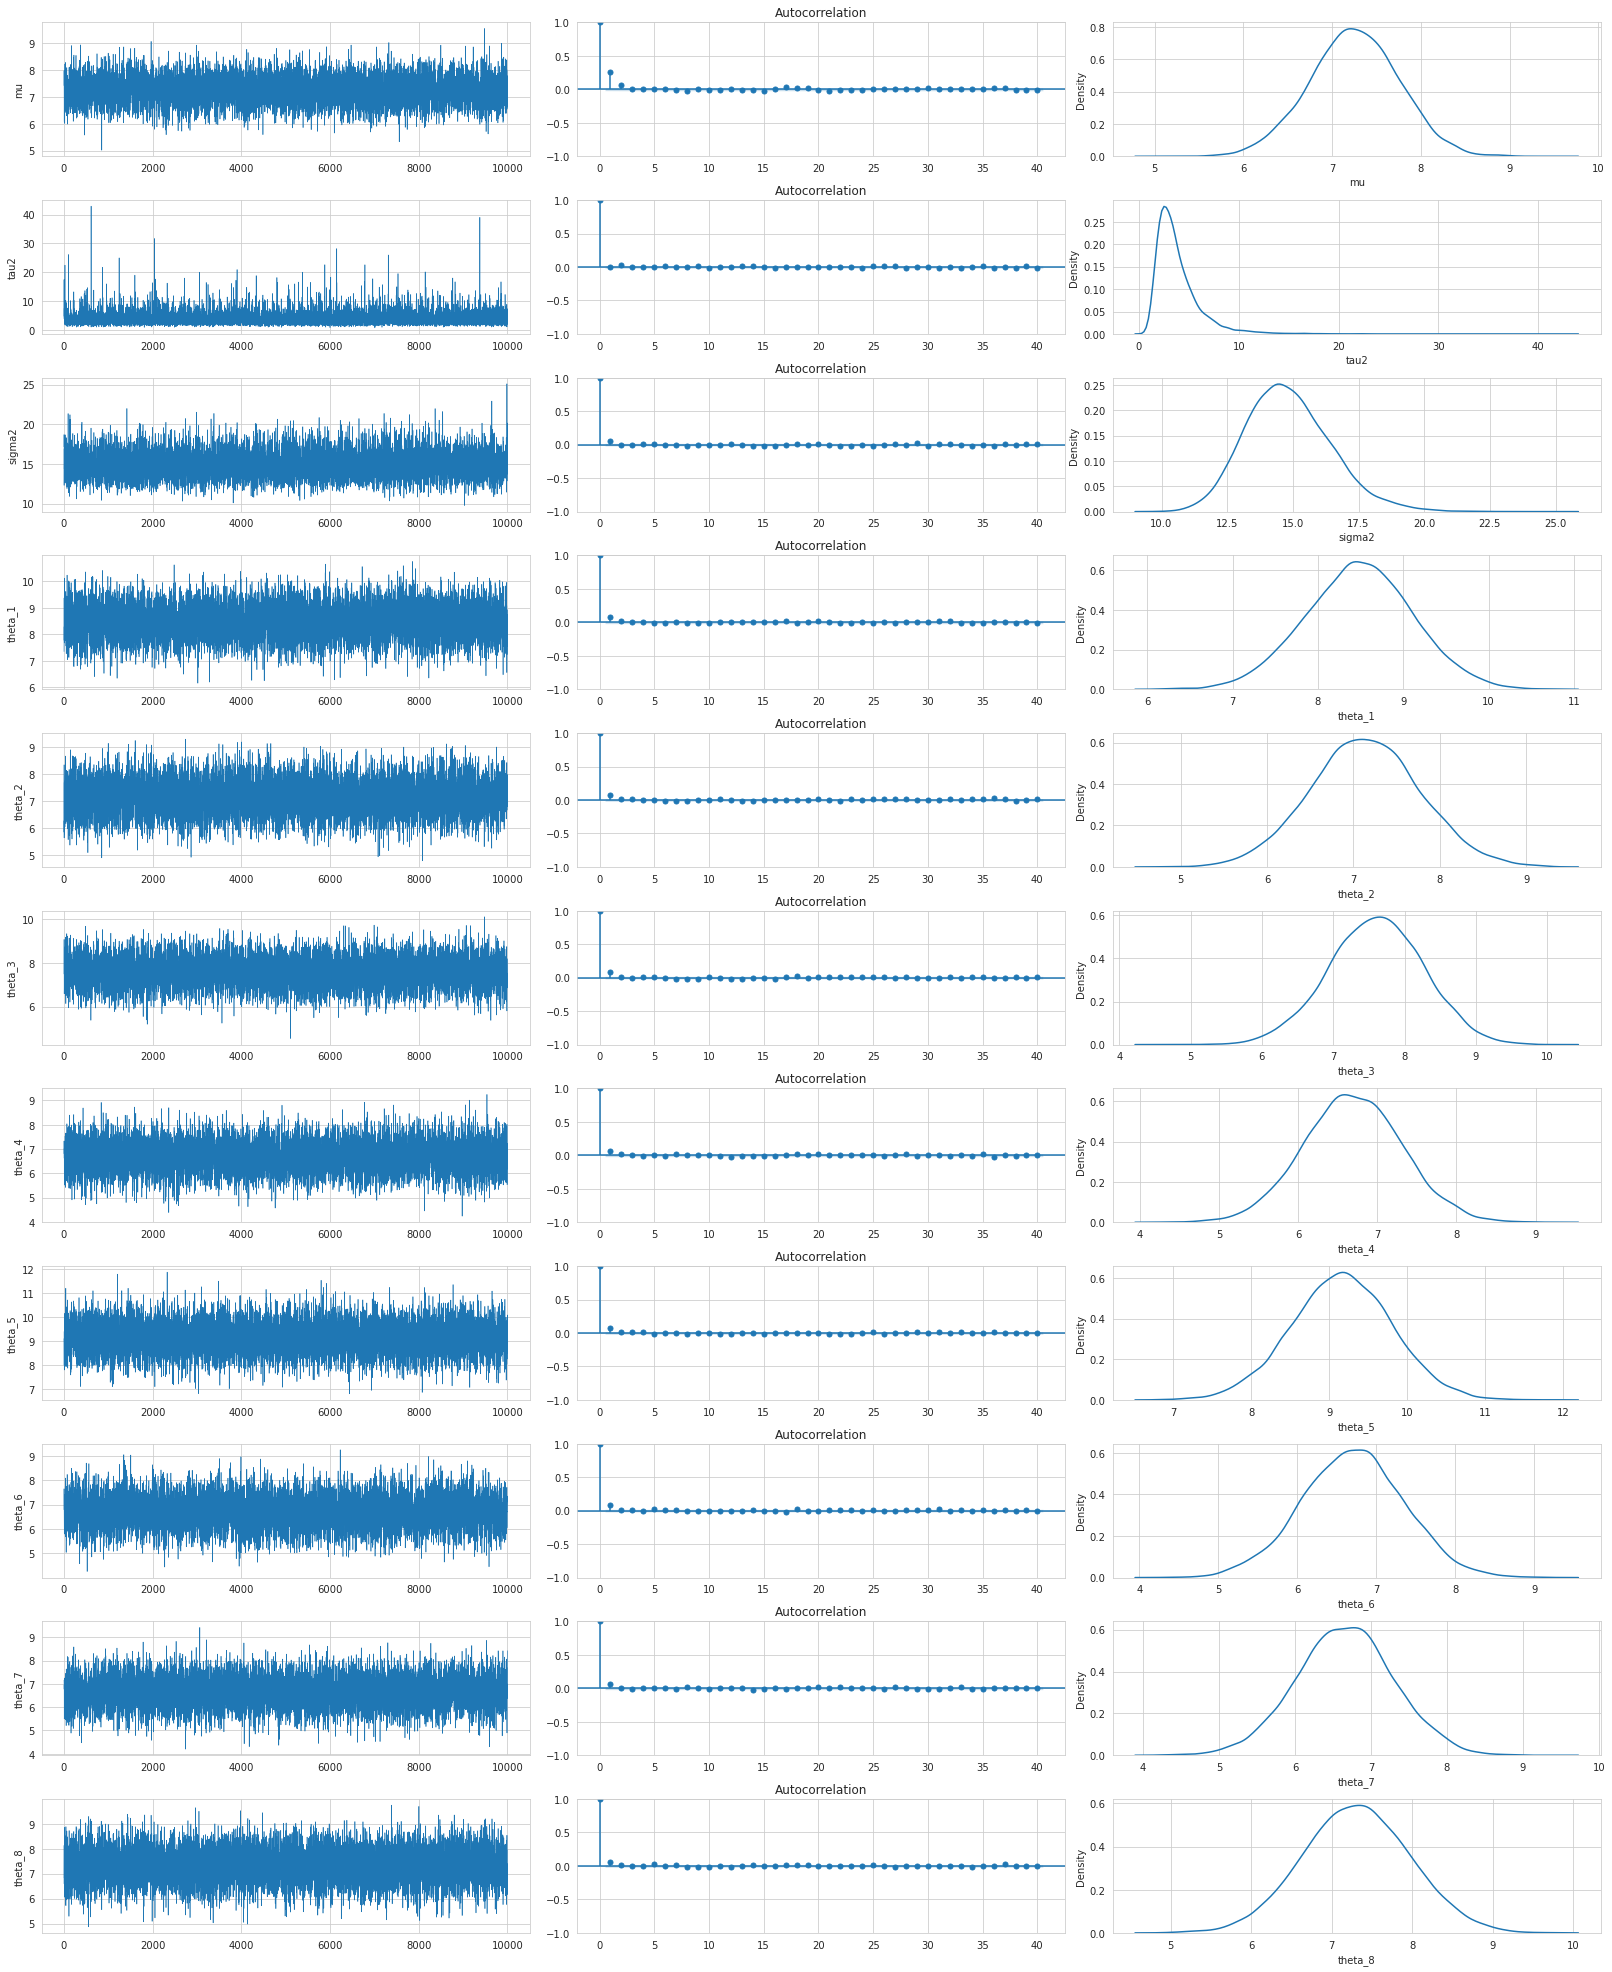

In [163]:
fig, ax = plt.subplots(11, 3, figsize=(7.5*3, 11*2.5))

for i, (col_name, sr) in enumerate(s.iteritems()):
    sr.plot(linewidth=0.6, label=col_name, ax=ax[i, 0])
    sm.graphics.tsa.plot_acf(sr, ax=ax[i, 1])
    sns.kdeplot(sr, ax=ax[i, 2])
    ax[i, 0].set_ylabel(col_name)

fig.tight_layout()
fig.show()

In [165]:
s.mean()

mu          7.249493
tau2        3.849585
sigma2     14.839811
theta_1     8.483323
theta_2     7.138862
theta_3     7.601586
theta_4     6.690515
theta_5     9.159375
theta_6     6.702851
theta_7     6.657871
theta_8     7.307186
dtype: float64

In [166]:
s.quantile([0.025, 0.975])

,mu,tau2,sigma2,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8
0.025,6.254261,1.421724,11.987797,7.246220,5.907865,6.288319,5.482026,7.878700,5.414409,5.398357,6.011407
0.975,8.221096,9.797242,18.392941,9.713393,8.396952,8.868660,7.934180,10.425107,7.961684,7.917403,8.606415


100%|██████████| 10000/10000 [00:00<00:00, 65258.55it/s]


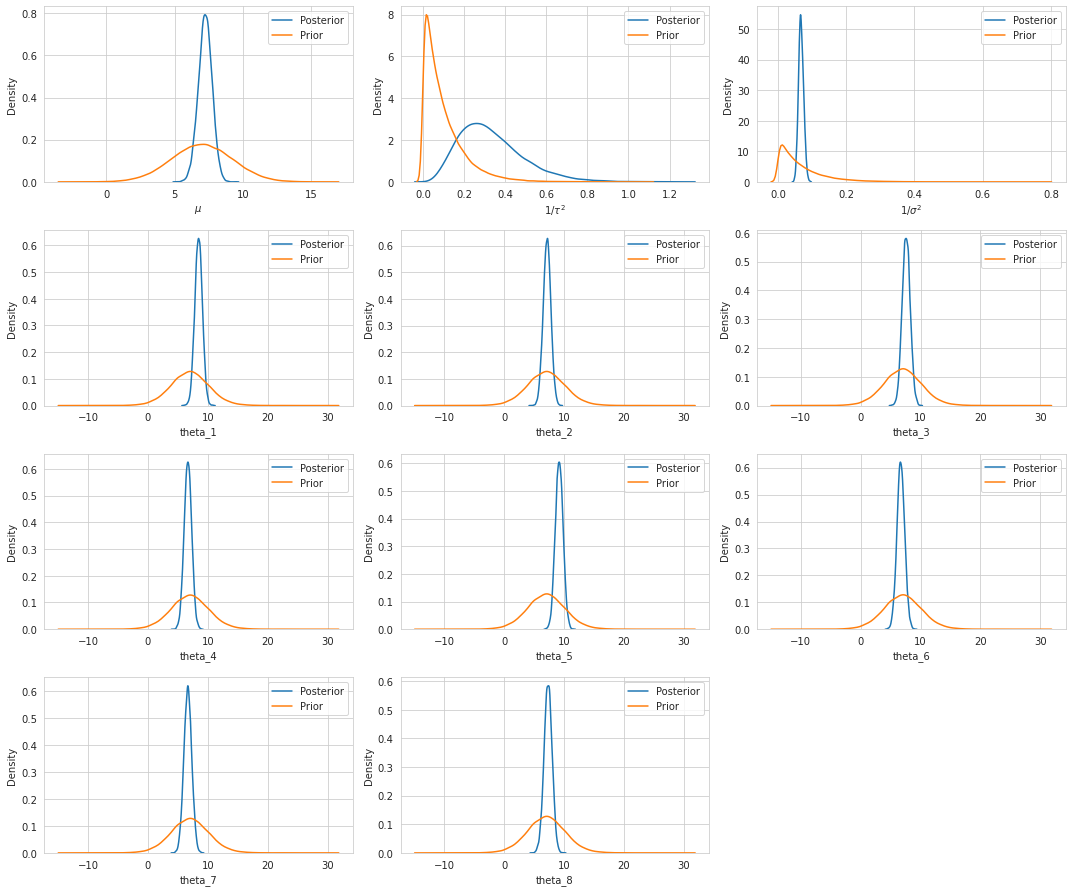

In [239]:
fig, ax = plt.subplots(4, 3, figsize=(15, 2.5 * 5))

sns.kdeplot(s.mu, label='Posterior', ax=ax[0,0])
sns.kdeplot(NormalMean(7, 5).sample_prior(size=100000), label='Prior', ax=ax[0,0])
ax[0,0].legend()
ax[0,0].set_xlabel("$\\mu$")

sns.kdeplot(1/s.tau2, label='Posterior', ax=ax[0,1])
sns.kdeplot(NomrlaPrec(2, 10).sample_prior(size=100000), label='Prior', ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_xlabel("$1/\\tau^2$")

sns.kdeplot(1/s.sigma2, label='Posterior', ax=ax[0,2])
sns.kdeplot(NomrlaPrec(2, 15).sample_prior(size=100000), label='Prior', ax=ax[0,2])
ax[0,2].legend()
ax[0,2].set_xlabel("$1/\\sigma^2$")

# theta prior baseline
n_epoch = 10000
np.random.seed(123)
θ_prior = []
for epoch in tqdm(range(n_epoch)):
    μ = μ_rv.sample_prior()[0]
    τ2 = 1/λ_rv.sample_prior()[0]
    θ_rv = NormalMean(μ, np.sqrt(τ2))
    θ_prior.append(θ_rv.sample_prior()[0])
    
for i, c in enumerate([col for col in s.columns if 'theta' in col]):
    ax_ij = ax[(i+3) // 3, (i+3) % 3]
    sns.kdeplot(s.loc[:, c], label='Posterior', ax=ax_ij)
    sns.kdeplot(θ_prior, label='Prior', ax=ax_ij)
    ax_ij.legend()

fig.delaxes(ax[3, 2])

fig.tight_layout()
fig.show()

100%|██████████| 10000/10000 [00:00<00:00, 88126.18it/s]


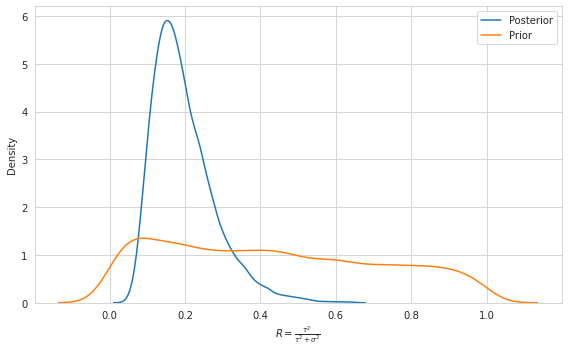

In [254]:
# theta prior baseline
n_epoch = 10000
np.random.seed(123)
R_prior = []
for epoch in tqdm(range(n_epoch)):
    τ2 = 1/λ_rv.sample_prior()[0]
    σ2 = 1/γ_rv.sample_prior()[0]
    R_prior.append(τ2/(τ2+σ2))

fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(s.tau2/(s.tau2+s.sigma2), label='Posterior', ax=ax)
sns.kdeplot(R_prior, label='Prior', ax=ax)
ax.set_xlabel("$R = \\frac{\\tau^2}{\\tau^2+\\sigma^2}$")
ax.legend()

fig.tight_layout()
fig.show()